# GEO877 Project    
**Authors:** *Alessandro Joshua Pierro 20-733-861, Alessandro Jud 19-754-613, Andreas Hvidt, Nina Moffat, Saskia Stierli*
**Date:** *2024-06-7*   
## Necessary Libraries
All the necessary libraries are imported in the following cell.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

## Class Definitions
The following cell contains all the necessary class definitions for the project. We based the classes on the ones explained in GEO877 and slightly modified them to fit our needs.

In [2]:
class Point():
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return f'Point(x={self.x:.2f}, y={self.y:.2f})'
    
    def distEuclidean(self, other):
        return np.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
    
    def __eq__(self, other): 
        if not isinstance(other, Point):
            return NotImplemented
        return self.x == other.x and self.y == self.y

class Segment():    
    def __init__(self, p0, p1, buffer=None):
        self.start = p0
        self.end = p1
        self.length = p0.distEuclidean(p1)
        self.buffer = buffer
    
    def __repr__(self):
        return f'Segment with start {self.start} and end {self.end}.' 

class Bbox():    
    def __init__(self, data):
        if isinstance(data, Segment):
            x = [data.start.x, data.end.x]
            y = [data.start.y, data.end.y]
        else:      
            x = [i.x for i in data]
            y = [i.y for i in data]
        self.ll = Point(min(x), min(y))
        self.ur = Point(max(x), max(y))
        self.ctr = Point((max(x)-min(x))/2, (max(y)-min(y))/2)
        self.area = (abs(max(x)-min(x)))*abs((max(y)-min(y)))    
           
    def containsPoint(self, p):
        if (self.ur.x >= p.x and p.x >= self.ll.x and
            self.ur.y >= p.y and p.y >= self.ll.y):
            return True
        return False

    def intersects(self, other):       
        if (self.ur.x > other.ll.x and other.ur.x > self.ll.x and
            self.ur.y > other.ll.y and other.ur.y > self.ll.y):
            return True
        else:
            return False

class Polygon():  
    def __init__(self, data=None, xcol=None, ycol=None):
        self.points = []
        if isinstance(data[0], Point):
            self.points = data
        else:
            for d in data:
                self.points.append(Point(d[xcol], d[ycol]))
        self.size = len(self.points)
        self.bbox = Bbox(self.points)
        
    def __repr__(self):
        return f'Polygon PointGroup containing {self.size} points' 

    def get_points(self):
        return self.points
    
    def intersects(self, other):
        if not self.bbox.intersects(other.bbox):
            return False
        
        for i in range(len(self.points) - 1):
            for j in range(len(other.points) - 1):
                if self.segments_intersect(Segment(self.points[i], self.points[i + 1], 0), Segment(other.points[j], other.points[j + 1], 0)):
                    return True
        return False
    
    def segments_intersect(self, seg1, seg2):
        def ccw(A, B, C):
            return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)
        
        A, B = seg1.start, seg1.end
        C, D = seg2.start, seg2.end
        
        return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)
    
    def union(self, other):
        new_points = self.points[:-1] + other.points[:-1]
        new_polygon = Polygon(data=new_points, xcol=0, ycol=1)
        return new_polygon

## Algorithms   
The following part contains the main algorithms used for the project. They are based on different algorithms and aim to reproduce the study conducted by Hakley (2010).
### Buffer Algorithm
The buffer algorithm works by:
- calculating a normal vector to the segment with lenght 1
- adding and subtracting the x/y component of the normal vector to each the start and end point of the segment
- creating a new polygon using these new x/y coordinates, which is the buffer polygon

In [3]:
def calculate_normal_vector(start, end):
    """
    Calculates the normal vector parameters (i.e. coordinates the normal
    vector's end point would have when starting from the origin) for a 
    normal vector to a segment

    :attrib start:
        the starting point of the segment as
        point object from geospatial class
    :attrib seg2:
        the end point of the segment as
        point object from geospatial class
    :returns:
        the parameter values as a tuple
    """
    dx = end.x - start.x
    dy = end.y - start.y
    length = np.sqrt(dx**2 + dy**2)
    nx = -dy / length
    ny = dx / length
    return (nx, ny)

def buffer_segment(segment, buffer_distance, extension_distance=0):
    """
    Generates a buffer polygon around a straight segment with a flat end.
    The end can be extended using the extension_distance.

    :attrib segment:
        segment to be buffered as segment object
        from geospatial class
    :attrib buffer_distance:
        the perpendicular distance to the segment
        by which the buffer should extend (in crs units)
    :attrib extension_distance:
        the distance, by which the flat end should extend
        from the ends of the segment (in crs units)
    :returns:
        the buffer as a Polygon object from geospatial class
    """
    # Calculate normal vector
    nx, ny = calculate_normal_vector(segment.start, segment.end)
    
    # Calculate the four corners of the buffer polygon
    buffer_points = [
        Point(segment.start.x + nx * buffer_distance, segment.start.y + ny * buffer_distance),
        Point(segment.end.x + nx * buffer_distance, segment.end.y + ny * buffer_distance),
        Point(segment.end.x - nx * buffer_distance, segment.end.y - ny * buffer_distance),
        Point(segment.start.x - nx * buffer_distance, segment.start.y - ny * buffer_distance),
        Point(segment.start.x + nx * buffer_distance, segment.start.y + ny * buffer_distance) # close the polygon
    ]
    
    return Polygon(data=buffer_points)

### Line Clipping using a polygon
The line clipping algorithm works by:
- using the parametrized form of the segment
- calculating a normal vector to each edge of the polygon
- calculating the dot product of the normal vector and the difference between the edge starting point and the segment starting point
- calculating the dot product of the normal vector and the segment vector
- divide the former dot product by the latter to get parameter t
- classify t as entering (tE, denominator > 0) or exiting (tL, denominator < 0)
- if 0 <= t <= 1 and tE < tL there is an intersection and the resulting segment is returned

In [7]:
def dot(p0, p1):
    """
    Dot product function for the poly_line_clip function.

    :attrib p0:
        point with xy-coordinates as list or tuple
    :attrib p1:
        point with xy-coordinates as list or tuple
    :returns:
        dot product of the two points
    """
    return p0[0] * p1[0] + p0[1] * p1[1]


def poly_line_clip(polygon, segment):
    """
    Clips a segment using a polygon overlay. Note, that since the
    algorithm is unable to deal with lines, that are parallel to edges
    of the polygon, the result is slightly inaccurate by introducing an
    artificial offset of 0.0001 crs units to one of the segment points.

    :attrib polygon:
        Polygon object with which the segment should be
        clipped, needs to be ordered anticlockwise (not checked,
        will return false result if not adhered to)
    :attrib segment:
        Segment object that is to be clipped
    :returns:
        the clipped segment as Segment object from geospatial
        class
    """
    n = len(polygon.points)
    P1_P0 = (segment.end.x + 0.0001 - segment.start.x, segment.end.y + 0.0001 - segment.start.y)
    normal = [(polygon.points[i].y - polygon.points[(i+1) % n].y, polygon.points[(i+1) % n].x - polygon.points[i].x) for i in range(n)]
    P0_PEi = [(polygon.points[i].x - segment.start.x, polygon.points[i].y - segment.start.y) for i in range(n)]
    numerator = [dot(normal[i], P0_PEi[i]) for i in range(n)]
    denominator = [dot(normal[i], P1_P0) for i in range(n)]
    t = [numerator[i] / denominator[i] if denominator[i] != 0 else 0 for i in range(n)]
    tE = [t[i] for i in range(n) if denominator[i] > 0]
    tL = [t[i] for i in range(n) if denominator[i] < 0]
    tE.append(0)
    tL.append(1)
    temp = [np.max(tE), np.min(tL)]
    if temp[0] > temp[1]:
        return None
    newSegment = Segment(Point(segment.start.x + P1_P0[0] * temp[0], segment.start.y + P1_P0[1] * temp[0]), 
                         Point(segment.start.x + P1_P0[0] * temp[1], segment.start.y + P1_P0[1] * temp[1]),
                         segment.buffer)
    return newSegment

### Gridding
The gridding is used to divide our data into smaller parts to reduce the computational time of the other algorithms. It works by:
- defining the total extent of the segments that are input to create a grid using a specified gridbox size (square boxes)
- every grid-cell is stored as a separate polygon
- for every grid-cell the algorithm loops over all segments, cuts the segments using the line-clipping algorithm, and stores the segments within the respective grid-cell in a new list
- this new list is appended to the list of all grid-cell segment-lists

In [5]:
def grid_segments(segment_list, gridbox_size):
    """
    Seperates segment data into grid-cells, using meters as
    gridbox size and squares as gridboxes.

    :attrib segment list:
        List of the segments to be separated into smaller
        "gridded" lists
    :attrib gridbox_size:
        Length and width of the square gridboxes in meters
    :returns:
        A list containing a list of segments for each gridbox
        and the clipping gridcells as a list of polygons
        (for visualization)
    """
    #initialize new segment list and grid polygons
    gridded_segments = []
    grid_polygons = []

    for i, segment in enumerate(segment_list):
        box = Bbox(segment)
        if i == 0:
            xmin, ymin, xmax, ymax = (box.ll.x, box.ll.y, box.ur.x, box.ur.y)
        else:
            if box.ll.x < xmin:
                xmin = box.ll.x
            if box.ll.y < ymin:
                ymin = box.ll.y
            if box.ur.x > xmax:
                xmax = box.ur.x
            if box.ur.y > ymax:
                ymax = box.ur.y

    x_extent = xmax - xmin
    y_extent = ymax - ymin
    x_cellcount = int((x_extent // gridbox_size) + 1)
    y_cellcount = int((y_extent // gridbox_size) + 1)

    for i in range(y_cellcount):
        for j in range(x_cellcount):
            poly = Polygon([[(j * gridbox_size) + xmin, (i * gridbox_size) + ymin],
                            [((j + 1) * gridbox_size) + xmin, (i * gridbox_size) + ymin],
                            [((j + 1) * gridbox_size) + xmin, ((i + 1) * gridbox_size) + ymin],
                            [(j * gridbox_size) + xmin, ((i + 1) * gridbox_size) + ymin],
                            [(j * gridbox_size) + xmin, (i * gridbox_size) + ymin]], xcol=0, ycol=1)
            grid_polygons.append(poly)

    for cell in grid_polygons:
        grid_segments = []
        for segment in segment_list:
            if Bbox(segment).intersects(cell.bbox):
                clipped_segment = poly_line_clip(cell, segment)
                if clipped_segment is not None:
                    grid_segments.append(clipped_segment)
        gridded_segments.append(grid_segments)

    return gridded_segments, grid_polygons

### Polygon-Polygon intersection
The polygon-polygon intersection algorithm works by:
- bounding box overlap is checked
- total containment of one polygon within the other is checked
- each edge of one polygon is cut by the other polygon using the line-clipping algorithm
- the start and end points of all intersected segments are stored for the new polygon
- all vertices of the other polygon contained by the first polygon are stored
- using the above two lists, a new polygon is created

In [6]:
def poly_poly_intersection(poly1, poly2):
    """
    Returns the intersection between two polygons as new polygon.

    :attrib poly1:
        first Polygon object for the intersection, needs to 
        be ordered anticlockwise (not checked, will return 
        false result if not adhered to)
    :attrib poly2:
        second Polygon object for the intersection, needs to 
        be ordered anticlockwise (not checked, will return 
        false result if not adhered to)
    :returns:
        the intersection result as Polygon object
    """
    #check for bounding box overlap:
    if poly1.bbox.intersects(poly2.bbox) == False:
        return None
    
    #check if poly1 totally within poly2
    if poly2.containsPoint(poly1.points[0]):
        if all([poly2.containsPoint(point) for point in poly1.points]):
            return poly1
    
    #check if poly2 totally within poly1
    if poly1.containsPoint(poly2.points[0]):
        if all([poly1.containsPoint(point) for point in poly2.points]):
            return poly2
        
    #otherwise, start iterating over segments of poly1 to find intersection segments
    intersection_segments = []
    for i in range(len(poly1.points)-1):
        seg = Segment(poly1.points[i], poly1.points[i+1])
        seg_int = poly_line_clip(poly2, seg)
        if seg_int is not None:
                intersection_segments.append(seg_int)        

    #extract vertices of intersection segments
    newpoly_vertices = []
    for edge in intersection_segments:
        newpoly_vertices.append([edge.start.x, edge.start.y])
    if len(intersection_segments) != 0:
        newpoly_vertices.append([intersection_segments[-1].end.x, intersection_segments[-1].end.y])
    
    # get all vertices of poly2 within poly1 (i.e. not on an intersection segment but
    # still part of the intersection polygon
    for i in range(len(poly2.points)-1):
         if poly1.containsPoint(poly2.points[i]):
              if [poly2.points[i].x, poly2.points[i].y] not in newpoly_vertices:
                newpoly_vertices.append([poly2.points[i].x, poly2.points[i].y])

    # append first point again to close polygon
    if len(intersection_segments) != 0:
        newpoly_vertices.append([intersection_segments[0].start.x,intersection_segments[0].start.y])
    
    if not newpoly_vertices:
        return None
    else:
        return Polygon(newpoly_vertices, xcol = 0, ycol = 1)

### Merge Polygons
The merge polygons algorithm works by (Somewhat based on the Greiner-Hormann clipping algorithm): 
- Checking for an overlap
- finding the intersections on the polygons
- inserting the intersection at the correct position into both list of points
- assembling the merged polygon based on if statements by essentially walking around the new polygon

NOTE: We haven't maneged to make this work with our data as we ran into to many edge cases when merging the polygons. Therefore we decided to use a library to merge the polygons to still have some results to present

First some helper functions to find intersections and then insert them into the polygon lists.

In [8]:
def find_intersections(poly1_coords, poly2_coords):
    """
    Finds all intersections between two polygons.

    :attrib poly1_coords:
        list of coordinates of the first polygon
    :attrib poly2_coords:
        list of coordinates of the second polygon

    :returns:
        list of tuples containing the coordinates of the
        intersecting segments (p1, p2, q1, q2, intersect_point)
        with p1 and p2 being the start and end points of the first segment,
        q1 and q2 being the start and end points of the second segment.
    """

    intersections = []
    # Iterate through the points to get the segments
    for i in range(len(poly1_coords) - 1):
        for j in range(len(poly2_coords) - 1):
            p1 = poly1_coords[i]
            p2 = poly1_coords[i + 1]
            q1 = poly2_coords[j]
            q2 = poly2_coords[j + 1]
            intersect_point = segment_intersection(p1, p2, q1, q2)
            if intersect_point:
                intersections.append((p1, p2, q1, q2, intersect_point))
    return intersections

def segment_intersection(p1, p2, q1, q2):
    """
    Return the intersection point of two segments if it exists.

    :attrib p1:
        start point of the first segment
    :attrib p2:
        end point of the first segment
    :attrib q1:
        start point of the second segment
    :attrib q2:
        end point of the second segment
    
    :returns:
        the intersection point as a list    
    """

    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    def intersect(A, B, C, D):
        return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

    if intersect(p1, p2, q1, q2):
        A1, B1 = p2[1] - p1[1], p1[0] - p2[0]
        C1 = A1 * p1[0] + B1 * p1[1]
        A2, B2 = q2[1] - q1[1], q1[0] - q2[0]
        C2 = A2 * q1[0] + B2 * q1[1]
        det = A1 * B2 - A2 * B1
        if det != 0:
            x = (B2 * C1 - B1 * C2) / det
            y = (A1 * C2 - A2 * C1) / det
            return [x, y]
    return None


def insert_intersections(poly_coords, intersections, polygon_index):
    """
    Inserts intersection points into the coordinates of a polygon.

    :param poly_coords: 
        List of tuples representing the coordinates of the polygon.
    :param intersections: 
        List of intersections where each intersection is represented by a tuple 
        containing the segment endpoints and the intersection point.
    :param polygon_index: 
        Integer specifying whether the intersections are for the first 
        or second polygon (value should be 1 or 2).
    
    :returns:
        List of tuples representing the new coordinates of the polygon with 
        the intersections inserted.
    
    The function ensures that the intersection points are added in the correct order 
    by sorting the intersection points for each segment based on their distance 
    from the starting point of the segment.
    Additionally the polygon_index is needed as the segments of the polygons are stored at different locations in the intersection tuples.
    """
    
    new_coords = []
    segments_with_intersections = {}

    # Group intersections by segments
    for intersection in intersections:
        # Determine the segment based on the polygon_index
        if polygon_index == 1:
            p1, p2 = tuple(intersection[0]), tuple(intersection[1])
        elif polygon_index == 2:
            p1, p2 = tuple(intersection[2]), tuple(intersection[3])
        
        # Initialize the list for this segment if not already present
        if (p1, p2) not in segments_with_intersections:
            segments_with_intersections[(p1, p2)] = []
        
        # Add the intersection point to the corresponding segment's list
        segments_with_intersections[(p1, p2)].append(intersection[4])

    # Iterate through each segment of the polygon
    for i in range(len(poly_coords) - 1):
        segment = (tuple(poly_coords[i]), tuple(poly_coords[i + 1]))
        new_coords.append(poly_coords[i])  # Add the start point of the segment
        
        # If the segment has intersections, sort and add them
        if segment in segments_with_intersections:
            # Sort intersection points based on their distance from the segment's start point
            sorted_intersections = sorted(
                segments_with_intersections[segment], 
                key=lambda p: (p[0] - segment[0][0]) ** 2 + (p[1] - segment[0][1]) ** 2
            )
            new_coords.extend(sorted_intersections)  # Add sorted intersection points
    
    new_coords.append(poly_coords[-1])  # Add the last point of the polygon
    return new_coords


This is just a function to make sure a polygon is closed so that the first and last point are the same.

In [9]:
def close_polygon(coords):
    """
    Closes a polygon by appending the first point to the end of the list.

    :attrib coords:
        list of coordinates as list of lists
    
    :returns:
        the closed polygon as list of lists    
    """
    if coords[0] != coords[-1]:
        coords.append(coords[0])

Next we have a function that checks if a point is inside the extent of a polygon.

In [10]:
def point_in_polygon(point, polygon_coords):
    """
    Function to check if a point is inside a polygon.

    :attrib point:
        the point to be checked as list
    :attrib polygon_coords:
        the coordinates of the polygon as list of lists
    :returns:
        boolean value indicating if the point is inside the polygon
    
    """
    x, y = point
    n = len(polygon_coords)
    inside = False
    px, py = polygon_coords[0]
    for i in range(1, n + 1):
        cx, cy = polygon_coords[i % n]
        if y > min(py, cy):
            if y <= max(py, cy):
                if x <= max(px, cx):
                    if py != cy:
                        xinters = (y - py) * (cx - px) / (cy - py) + px
                    if px == cx or x <= xinters:
                        inside = not inside
        px, py = cx, cy
    return inside

Then we have some fuctions that help excluding some edge cases for example if a point is on the edge of the other polygon.

In [11]:
def polygons_overlap(poly1_coords, poly2_coords):
    """
    Checks if two polygons overlap.

    :attrib poly1_coords:
        list of coordinates of the first polygon    
    :attrib poly2_coords:  
        list of coordinates of the second polygon
    :returns:
        True if the polygons overlap, False otherwise   
    """
    # Check if any vertex of poly1 is inside poly2
    for point in poly1_coords:
        if point_in_polygon(point, poly2_coords):
            return True

    #Check if any vertex of poly2 is inside poly1
    for point in poly2_coords:
        if point_in_polygon(point, poly1_coords):
            return True

    #Check if any edge of poly1 intersects with any edge of poly2
    for i in range(len(poly1_coords) - 1):
        for j in range(len(poly2_coords) - 1):
            p1 = poly1_coords[i]
            p2 = poly1_coords[i + 1]
            q1 = poly2_coords[j]
            q2 = poly2_coords[j + 1]
            if segment_intersection(p1, p2, q1, q2):
                return True

    return False


def point_on_segment(p, q1, q2):
    """Check if point p lies on segment q1q2."""
    if min(q1[0], q2[0]) <= p[0] <= max(q1[0], q2[0]) and min(q1[1], q2[1]) <= p[1] <= max(q1[1], q2[1]):
        if (q2[0] - q1[0]) * (p[1] - q1[1]) == (q2[1] - q1[1]) * (p[0] - q1[0]):
            return True
    return False


def edge_function(poly1_coords, poly2_coords):
    """
    Checks if any point of poly1 lies on an edge of poly2 or vice versa.

    :attrib poly1_coords:
        list of coordinates of the first polygon
    :attrib poly2_coords:
        list of coordinates of the second polygon
    :returns:
        True if any point of poly1 lies on an edge of poly2 or vice versa  
    
    """

    # Check if any point of poly1 lies on an edge of poly2
    p1_on_p2 = False
    for point in poly1_coords:
        for i in range(len(poly2_coords) - 1):
            if point_on_segment(point, poly2_coords[i], poly2_coords[i + 1]):
                p1_on_p2 = True
                break
    # Check if any point of poly2 lies on an edge of poly1
    p2_on_p1 = False
    for point in poly2_coords:
        for i in range(len(poly1_coords) - 1):
            if point_on_segment(point, poly1_coords[i], poly1_coords[i + 1]):
                p2_on_p1 = True
                break
    return p1_on_p2 or p2_on_p1 # Return True if any point of poly1 lies on an edge of poly2 or vice versa

In [12]:
def assemble_merged_polygon(poly1_coords, poly2_coords, intersections):
    """
    Assembles the merged polygon from the two input polygons and the intersection points.

    :attrib poly1_coords:
        the coordinates of the first polygon as list of lists
    :attrib poly2_coords:
        the coordinates of the second polygon as list of lists
    :attrib intersections:
        the intersection points as list of tuples with the format (p1, q1, p2, q4, intersection_point)  
        with p1 and q1 being the points of the first segement and p2 and q2 being the points of the second segment of the intersection
    :returns:
        the merged polygon as list of lists
    """
    # Frist the insert_intersections function is called to insert the intersection points into the polygon coordinates
    poly1_coords = insert_intersections(poly1_coords, intersections,1)
    poly2_coords = insert_intersections(poly2_coords, intersections,2)
   
    # Next some helper functions are defined
    # function to switch between the two polygons
    def switch_poly(poly):
        """
        Switches between the two polygons.
        """
        return poly2_coords if poly == poly1_coords else poly1_coords
    
    # function to get the index of a point in a polygon
    def get_current_index(poly,point):
        """
        Get the index of a point in a polygon.
        """
        return poly.index(point)

    # function to get the next point in a polygon
    def get_next_point(poly,index):
        """
        Get the next point in a polygon. The function would loop back to the first point if the index is the last point in the polygon.
        """
        return poly[(index + 1) % len(poly)]   
    
    # We'll also need a list of all intersection points
    list_intersections = [i[4] for i in intersections]

    # Initialize the merged polygon as a list
    merged_polygon = [] 
    
    # start with the first intersection and add it to the merged polygon
    merged_polygon.append(intersections[0][4])


    # define the current polygon and the index as well as the current point based on the first intersection
    current_poly = poly1_coords
    current_index = get_current_index(current_poly,intersections[0][4])
    current_point = current_poly[current_index]

    # And we define the next_point_current as None for now it will be the next point in the current polygon
    next_point_current= None
    
    # Now this while loop will assemble the merged polygon and run until the next points it wants to add would be the first intersection point again
    while not next_point_current==intersections[0][4]:
        # First the next_point_current meaning the next point in the current polygon is
        next_point_current = get_next_point(current_poly, current_index)
        """
        While loop to assemble the merged polygon.

        The while loop will run until the next points it wants to add would be the first intersection point again.

        Multiple if-else statements are used to determine if we add the next point or have to switch the polygon. 
        
        """

        # Checking if the next point is an intersection point and if the current point is an intersection point as well:
        # There is no way two intersection points are next to each other in the merged polygon so we have to switch the polygon
        if next_point_current in list_intersections and current_point in list_intersections:
            current_poly = switch_poly(current_poly)
            current_index = get_current_index(current_poly, current_point)
            next_point_current = get_next_point(current_poly, current_index)
            merged_polygon.append(next_point_current)
            current_point = next_point_current
            current_index = get_current_index(current_poly, current_point)

        # Checking if the next point is an intersection point:
        # We add the intersection point to the merged polygon and switch the polygon
        elif next_point_current in list_intersections:
            merged_polygon.append(next_point_current)
            current_poly = switch_poly(current_poly)
            current_index = get_current_index(current_poly, next_point_current)
            current_point = next_point_current
            next_point_current = get_next_point(current_poly, current_index)
            
        # Checking if the next point we want to add is already in the merged polygon:
        # In which case we assume that we are at the end of a polygon (as the polygons are closed) and just have to go to the next point in the current polygon without adding the point
        elif next_point_current in merged_polygon:
            current_index = get_current_index(current_poly, next_point_current)
            current_point = next_point_current
            next_point_current = get_next_point(current_poly, current_index)

        # Checking if the next point is inside of the other polygon:
        # In which case we dont add the point and switch instead to the other polygon and add the next point there
        elif point_in_polygon(next_point_current, switch_poly(current_poly)):
            current_poly = switch_poly(current_poly)
            current_index = get_current_index(current_poly, current_point)
            next_point_current = get_next_point(current_poly, current_index)
            current_point = next_point_current
            merged_polygon.append(next_point_current)

      
        
        else:
            merged_polygon.append(next_point_current)
            current_index = get_current_index(current_poly, next_point_current)
            current_point = next_point_current
            next_point_current = get_next_point(current_poly, current_index)
    

    return merged_polygon

idk

In [13]:
def union(poly1, poly2):
    """
    Returns the union of two polygons as new polygon. Calling function for the merging of two polygons.

    :attrib poly1:
        first Polygon object for the union
    :attrib poly2:
        second Polygon object for the union
    :returns:
        the union result as Polygon object
    """
    # Extract the coordinates of the polygons as the other merge functions run on lists of lists
    poly1_coords = [[i.x, i.y] for i in poly1.points]
    poly2_coords = [[i.x, i.y] for i in poly2.points]

    intersections = find_intersections(poly1_coords, poly2_coords)

    # If somehow the merge_polygons functions thinks the polygons overlap but we can't find any intersections we return the first polygon and don't merge
    if not intersections:
        return poly1
    
    # Calling the merge function that will assemble the merged polygon
    merged_coords = assemble_merged_polygon(poly1_coords, poly2_coords, intersections)

    close_polygon(merged_coords) # Close the polygon by appending the first point again
    
    return Polygon([list(coord) for coord in merged_coords], 0, 1)


Next is the Calling function that makes sure to only call the union function if the polygons actually overlap.

In [14]:
def merge_polygons(gridded_buffered_segments):
    """
    Runs through a list of gridded buffered segments to loop through the polygons and merge them if they intersect.

    :attrib buffered_segments:
        list of buffered segments as list of Polygon objects
    
    :returns:
        lists of grids with merged polygons
    """
    merged_gridded_buffered_segments = [] # Initialize the list to store the grids with merged polygons
    
    # Loop through the grids of buffered segments
    for buffered_segments in gridded_buffered_segments:
        # Clone the list of buffers to not change the original list
        merged_polygons = buffered_segments[:]
        
        #total_polygons = len(merged_polygons) 
        # merged_count = 0 // Commented out as its not needed anymore withtout the print statements
        
        # Use While loop instead of a for loop to be able to change the merged_polygons list without running into index errors
        i = 0
        while i < len(merged_polygons):
            poly1 = merged_polygons[i]
            j = i + 1
            while j < len(merged_polygons):
                poly2 = merged_polygons[j]
                
                if poly1 == poly2:  # Check if the polygons are the same
                    j += 1
                    continue
                
                # Check if the bounding boxes of the polygons overlap; if not, skip as the polygons cannot intersect
                if not poly1.bbox.intersects(poly2.bbox):
                    j += 1
                    continue
                
                # Take the coordinates of the polygons
                poly1_coords = [[p.x, p.y] for p in poly1.points]
                poly2_coords = [[p.x, p.y] for p in poly2.points]

                # Check if all the points in poly2 are inside poly1; if so, remove poly2 and continue
                if all([point_in_polygon(point, poly1_coords) for point in poly2_coords]):
                    merged_polygons.pop(j)
                    merged_count += 1
                    continue

                #print(f'This is the first polygon: {poly1_coords}')
                #print(f'This is the second polygon: {poly2_coords}') // Commented out to avoid too many print statements
                
                # Check if a point or an edge lies on the edge of the other polygon to avoid these edge cases
                if edge_function(poly1_coords, poly2_coords):
                    # If the edge function returns True, we still have to check for other intersections to then not run into the same problematic edge case; 0.0001 is added to the coordinates of poly2
                    if polygons_overlap(poly1_coords, poly2_coords):
                        # Add 0.0001 to the coordinates of poly2
                        poly2_coords = [[p[0] + 0.0001, p[1] + 0.0001] for p in poly2_coords]
                        if polygons_overlap(poly1_coords, poly2_coords):
                            poly2_offset = Polygon(poly2_coords, 0, 1)
                            unioned = union(poly1, poly2_offset)  # Call the union function with the new poly2
                            merged_polygons[i] = unioned  # Replace the old poly1 with the new unioned polygon to continuously merge the polygons
                            merged_polygons.pop(j)
                            merged_count += 1
                            poly1 = unioned
                            #print(f"Polygons merged: {merged_count}, Polygons left: {total_polygons - merged_count}") // Commented out to avoid too many print statements
                        continue
                    j += 1
                    continue
                
                # When no edge case is detected, we test for overlap, and if the polygons overlap, we call the union function
                elif polygons_overlap(poly1_coords, poly2_coords):
                    unioned = union(poly1, poly2)
                    merged_polygons[i] = unioned  # Replace the old poly1 with the new unioned polygon to continuously merge the polygons
                    merged_polygons.pop(j)
                    merged_count += 1
                    poly1 = unioned
                    #print(f"Polygons merged: {merged_count}, Polygons left: {total_polygons - merged_count}") // Commented out to avoid too many print statements
                    continue
                
                j += 1
            i += 1
        
        print(f'This is the final merged polygon: {merged_polygons}')
        merged_gridded_buffered_segments.append(merged_polygons)
    
    return merged_gridded_buffered_segments


## Functions
The below functions are used to run the algorithms and perform our analysis.
### Functions to Load Data
The functions is used to load the data and directly put them into the segment class

In [15]:
def load_segments_from_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    segments = []
    for feature in data['features']:
        coords = feature['geometry']['coordinates']
        buffer_distance = feature['properties'].get('buffer', 0)  # Change here to get the buffer value
        if isinstance(coords[0], list):
            if isinstance(coords[0][0], list):
                for subcoords in coords:
                    for i in range(len(subcoords) - 1):
                        p1 = Point(subcoords[i][0], subcoords[i][1])
                        p2 = Point(subcoords[i + 1][0], subcoords[i + 1][1])
                        segments.append(Segment(p1, p2, buffer_distance))
            else:
                for i in range(len(coords) - 1):
                    p1 = Point(coords[i][0], coords[i][1])
                    p2 = Point(coords[i + 1][0], coords[i + 1][1])
                    segments.append(Segment(p1, p2, buffer_distance))
        else:
            p1 = Point(coords[0], coords[1])
            p2 = Point(coords[2], coords[3])
            segments.append(Segment(p1, p2, buffer_distance))
    return segments

### Function to Buffer the Segments
This function calls the buffer algorithm and buffers the segments.

In [16]:
def buffer_segments(gridded_segments, extension_distance=0):
    gridded_buffered_segments = []
    for seg_l in gridded_segments:
        buffered_segments = []
        for seg in seg_l:
            buffered_seg = buffer_segment(seg, seg.buffer, extension_distance)
            buffered_segments.append(buffered_seg)
        gridded_buffered_segments.append(buffered_segments)
    return gridded_buffered_segments

### Test functions
The test functions are used to test the algorithms and check if they work as expected.
#### Test segments and buffer

In [17]:
def plot_segment_and_buffer(segment, buffered_segment, title):
    plt.figure(figsize=(10, 10))
    
    # Plot the original segment
    x_segment = [segment.start.x, segment.end.x]
    y_segment = [segment.start.y, segment.end.y]
    plt.plot(x_segment, y_segment, marker='o', label='Original Segment')
    
    # Plot the buffered polygon
    x_buffer = [point.x for point in buffered_segment.get_points()]
    y_buffer = [point.y for point in buffered_segment.get_points()]
    plt.plot(x_buffer, y_buffer, marker='o', label='Buffered Segment')
    
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

#### Test gridding and buffering

In [18]:
def plot_grid_cells_with_buffers(gridded_buffer_l, grid_polygons, max_cells_per_figure=9):
    cells_with_buffers = [(grid, buffers) for grid, buffers in zip(grid_polygons, gridded_buffer_l) if buffers]
    
    num_cells = len(cells_with_buffers)
    if num_cells == 0:
        print("No grid cells contain buffered segments.")
        return

    num_figures = (num_cells // max_cells_per_figure) + (num_cells % max_cells_per_figure > 0)
    
    for fig_index in range(num_figures):
        start_index = fig_index * max_cells_per_figure
        end_index = min(start_index + max_cells_per_figure, num_cells)
        
        cells_to_plot = cells_with_buffers[start_index:end_index]
        cols = 3
        rows = (len(cells_to_plot) // cols) + (len(cells_to_plot) % cols > 0)

        fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
        axs = axs.flatten()

        for i, (grid, buffers) in enumerate(cells_to_plot):
            x_grid = [point.x for point in grid.get_points()]
            y_grid = [point.y for point in grid.get_points()]
            axs[i].plot(x_grid, y_grid, 'k-', linewidth=1, label='Grid Cell')
            
            for buffer in buffers:
                x_buffer = [point.x for point in buffer.get_points()]
                y_buffer = [point.y for point in buffer.get_points()]
                axs[i].plot(x_buffer, y_buffer, marker='o')
            
            axs[i].set_title(f'Grid Cell {start_index + i}')
            axs[i].set_xlabel('Longitude')
            axs[i].set_ylabel('Latitude')

        for j in range(len(cells_to_plot), len(axs)):
            fig.delaxes(axs[j])

        plt.tight_layout()
        plt.show()

## Data Loading

In [21]:
# Set base data path (one level up from the current working directory)
base_data_path = "../data/geojson/"

# Define paths for Zurich and Graubunden, Swiss Topo and OSM data
zurich_swisstopo_path = base_data_path + "zurich/swisstopo/"
graubunden_swisstopo_path = base_data_path + "graubunden/swisstopo/"

zurich_osm_path = base_data_path + "zurich/osm/"
graubunden_osm_path = base_data_path + "graubunden/osm/"

# Load Swiss Topo geojsons for Zurich
motorway_zh_swisstopo_segments = load_segments_from_geojson(zurich_swisstopo_path + "motorway_zh_swisstopo.geojson")
mainroads_zh_swisstopo_segments = load_segments_from_geojson(zurich_swisstopo_path + "mainroads_zh_swisstopo.geojson")
smallpaths_zh_swisstopo_segments = load_segments_from_geojson(zurich_swisstopo_path + "smallpaths_zh_swisstopo.geojson")
print("Loaded Swiss Topo data for Zurich")


# Load Swiss Topo geojsons for Graubunden
motorway_gr_swisstopo_segments = load_segments_from_geojson(graubunden_swisstopo_path + "motorway_gr_swisstopo.geojson")
mainroads_gr_swisstopo_segments = load_segments_from_geojson(graubunden_swisstopo_path + "mainroads_gr_swisstopo.geojson")
smallpaths_gr_swisstopo_segments = load_segments_from_geojson(graubunden_swisstopo_path + "smallpaths_gr_swisstopo.geojson")
print("Loaded Swiss Topo data for Graubunden")

# Load OSM geojsons for Zurich
motorway_zh_osm_segments = load_segments_from_geojson(zurich_osm_path + "motorway_zh_osm.geojson")
mainroads_without_zh_osm_segments = load_segments_from_geojson(zurich_osm_path + "mainroads_without_zh_osm.geojson")
mainroads_with_zh_osm_segments = load_segments_from_geojson(zurich_osm_path + "mainroads_with_zh_osm.geojson")
smallpaths_without_zh_osm_segments = load_segments_from_geojson(zurich_osm_path + "smallpaths_without_zh_osm.geojson")
smallpaths_with_zh_osm_segments = load_segments_from_geojson(zurich_osm_path + "smallpaths_with_zh_osm.geojson")
print("Loaded OSM data for Zurich")

# Load OSM geojsons for Graubunden
motorway_gr_osm_segments = load_segments_from_geojson(graubunden_osm_path + "motorway_gr_osm.geojson")
mainroads_without_gr_osm_segments = load_segments_from_geojson(graubunden_osm_path + "mainroads_without_gr_osm.geojson")
mainroads_with_gr_osm_segments = load_segments_from_geojson(graubunden_osm_path + "mainroads_with_gr_osm.geojson")
smallpaths_without_gr_osm_segments = load_segments_from_geojson(graubunden_osm_path + "smallpaths_without_gr_osm.geojson")
smallpaths_with_gr_osm_segments = load_segments_from_geojson(graubunden_osm_path + "smallpaths_with_gr_osm.geojson")
print("Loaded OSM data for Graubunden")


Loaded Swiss Topo data for Zurich
Loaded Swiss Topo data for Graubunden
Loaded OSM data for Zurich
Loaded OSM data for Graubunden


## Data Processing


### Gridding the segments

In [22]:
# Gridding the segments for Zurich and Graubunden before buffering
gridbox_size = 10000  # 10 km grid box size

# Grid the swisstopo segments for Zurich
gridded_motorway_zh_swisstopo, grid_polygons_motorway_zh_swisstopo = grid_segments(motorway_zh_swisstopo_segments, gridbox_size)
gridded_mainroads_zh_swisstopo, grid_polygons_mainroads_zh_swisstopo = grid_segments(mainroads_zh_swisstopo_segments, gridbox_size)
gridded_smallpaths_zh_swisstopo, grid_polygons_smallpaths_zh_swisstopo = grid_segments(smallpaths_zh_swisstopo_segments, gridbox_size)
print("Gridded all the swisstopo segments for Zurich")

# Grid the osm segments for Graubunden
gridded_motorway_zh_osm, grid_polygons_motorway_zh_osm = grid_segments(motorway_zh_osm_segments, gridbox_size)
gridded_mainroads_without_zh_osm, grid_polygons_mainroads_without_zh_osm = grid_segments(mainroads_without_zh_osm_segments, gridbox_size)
gridded_mainroads_with_zh_osm, grid_polygons_mainroads_with_zh_osm = grid_segments(mainroads_with_zh_osm_segments, gridbox_size)
gridded_smallpaths_without_zh_osm, grid_polygons_smallpaths_without_zh_osm = grid_segments(smallpaths_without_zh_osm_segments, gridbox_size)
gridded_smallpaths_with_zh_osm, grid_polygons_smallpaths_with_zh_osm = grid_segments(smallpaths_with_zh_osm_segments, gridbox_size)
print("Gridded all the osm segments for Zurich")

# Grid the swisstopo segments for Graubunden
gridded_motorway_gr_swisstopo, grid_polygons_motorway_gr_swisstopo = grid_segments(motorway_gr_swisstopo_segments, gridbox_size)
gridded_mainroads_gr_swisstopo, grid_polygons_mainroads_gr_swisstopo = grid_segments(mainroads_gr_swisstopo_segments, gridbox_size)
gridded_smallpaths_gr_swisstopo, grid_polygons_smallpaths_gr_swisstopo = grid_segments(smallpaths_gr_swisstopo_segments, gridbox_size)
print("Gridded all the swisstopo segments for Graubunden")

# Grid the osm segments for Graubunden
gridded_motorway_gr_osm, grid_polygons_motorway_gr_osm = grid_segments(motorway_gr_osm_segments, gridbox_size)
gridded_mainroads_without_gr_osm, grid_polygons_mainroads_without_gr_osm = grid_segments(mainroads_without_gr_osm_segments, gridbox_size)
gridded_mainroads_with_gr_osm, grid_polygons_mainroads_with_gr_osm = grid_segments(mainroads_with_gr_osm_segments, gridbox_size)
gridded_smallpaths_without_gr_osm, grid_polygons_smallpaths_without_gr_osm = grid_segments(smallpaths_without_gr_osm_segments, gridbox_size)
gridded_smallpaths_with_gr_osm, grid_polygons_smallpaths_with_gr_osm = grid_segments(smallpaths_with_gr_osm_segments, gridbox_size)
print("Gridded all the osm segments for Graubunden")
print("Gridded all segments")


Gridded all the swisstopo segments for Zurich
Gridded all the osm segments for Zurich
Gridded all the swisstopo segments for Graubunden
Gridded all the osm segments for Graubunden
Gridded all segments


### Buffering the Segments

In [23]:
# Buffer the segments for Zurich and Graubunden
buffered_motorway_zh_swisstopo = buffer_segments(gridded_motorway_zh_swisstopo)
buffered_mainroads_zh_swisstopo = buffer_segments(gridded_mainroads_zh_swisstopo)
buffered_smallpaths_zh_swisstopo = buffer_segments(gridded_smallpaths_zh_swisstopo)
print("Buffered Swiss Topo segments for Zurich")


buffered_motorway_zh_osm = buffer_segments(gridded_motorway_zh_osm)
buffered_mainroads_without_zh_osm = buffer_segments(gridded_mainroads_without_zh_osm)
buffered_mainroads_with_zh_osm = buffer_segments(gridded_mainroads_with_zh_osm)
buffered_smallpaths_without_zh_osm = buffer_segments(gridded_smallpaths_without_zh_osm)
buffered_smallpaths_with_zh_osm = buffer_segments(gridded_smallpaths_with_zh_osm)
print("Buffered OSM segments for Zurich")

buffered_motorway_gr_swisstopo = buffer_segments(gridded_motorway_gr_swisstopo)
buffered_mainroads_gr_swisstopo = buffer_segments(gridded_mainroads_gr_swisstopo)
buffered_smallpaths_gr_swisstopo = buffer_segments(gridded_smallpaths_gr_swisstopo)
print("Buffered Swiss Topo segments for Graubunden")

buffered_motorway_gr_osm = buffer_segments(gridded_motorway_gr_osm)
buffered_mainroads_without_gr_osm = buffer_segments(gridded_mainroads_without_gr_osm)
buffered_mainroads_with_gr_osm = buffer_segments(gridded_mainroads_with_gr_osm)
buffered_smallpaths_without_gr_osm = buffer_segments(gridded_smallpaths_without_gr_osm)
buffered_smallpaths_with_gr_osm = buffer_segments(gridded_smallpaths_with_gr_osm)
print("Buffered OSM segments for Graubunden")


print("Buffered all segments")

Buffered Swiss Topo segments for Zurich
Buffered OSM segments for Zurich
Buffered Swiss Topo segments for Graubunden
Buffered OSM segments for Graubunden
Buffered all segments


Test if everythink worked:

Original Segment Coordinates:
Start: (2675709.697000042, 1236040.1919967746)
End: (2675710.9471000414, 1236041.8060967776)

Buffered Segment Coordinates:
(2675701.000276142, 1236046.9274992358)
(2675702.250376141, 1236048.5415992388)
(2675719.6438239417, 1236035.0705943163)
(2675718.3937239423, 1236033.4564943134)
(2675701.000276142, 1236046.9274992358)


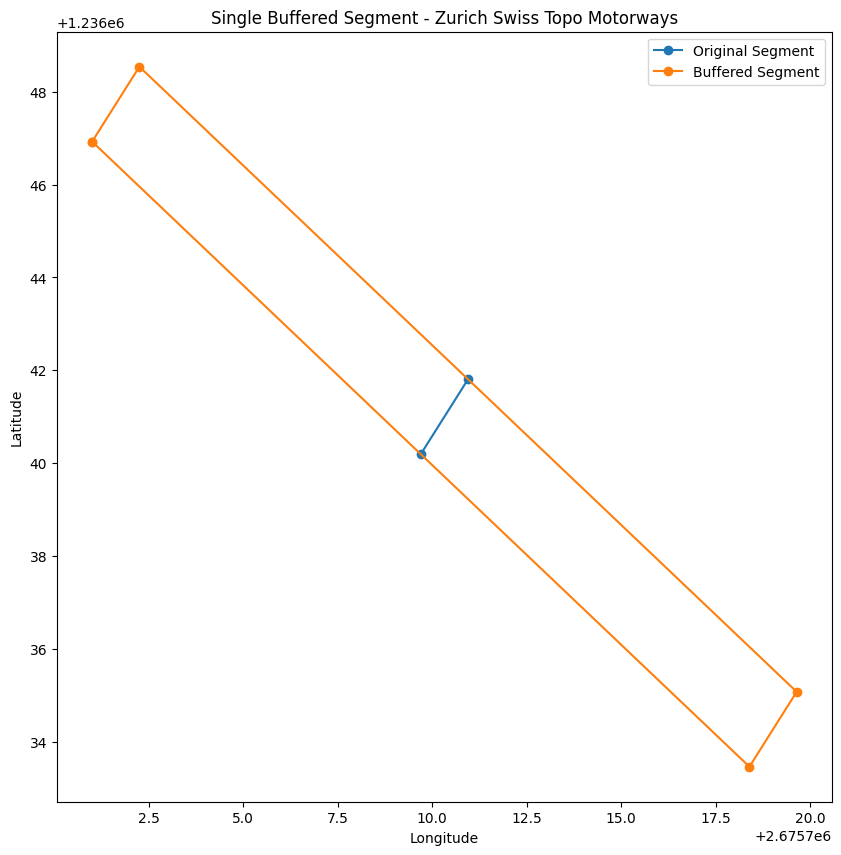

In [24]:
def output_coordinates(segment, buffered_segment):
    print("Original Segment Coordinates:")
    print(f"Start: ({segment.start.x}, {segment.start.y})")
    print(f"End: ({segment.end.x}, {segment.end.y})")
    
    print("\nBuffered Segment Coordinates:")
    for point in buffered_segment.get_points():
        print(f"({point.x}, {point.y})")

# Select a single buffered segment from Zurich Swiss Topo motorways
buffered_segment_to_plot = buffered_motorway_zh_swisstopo[0][0]  # Example: first segment of the first grid cell
original_segment_to_plot = gridded_motorway_zh_swisstopo[0][0]  # Corresponding original segment

# Output the coordinates
output_coordinates(original_segment_to_plot, buffered_segment_to_plot)

# Plotting the segments again
plot_segment_and_buffer(original_segment_to_plot, buffered_segment_to_plot, 'Single Buffered Segment - Zurich Swiss Topo Motorways')

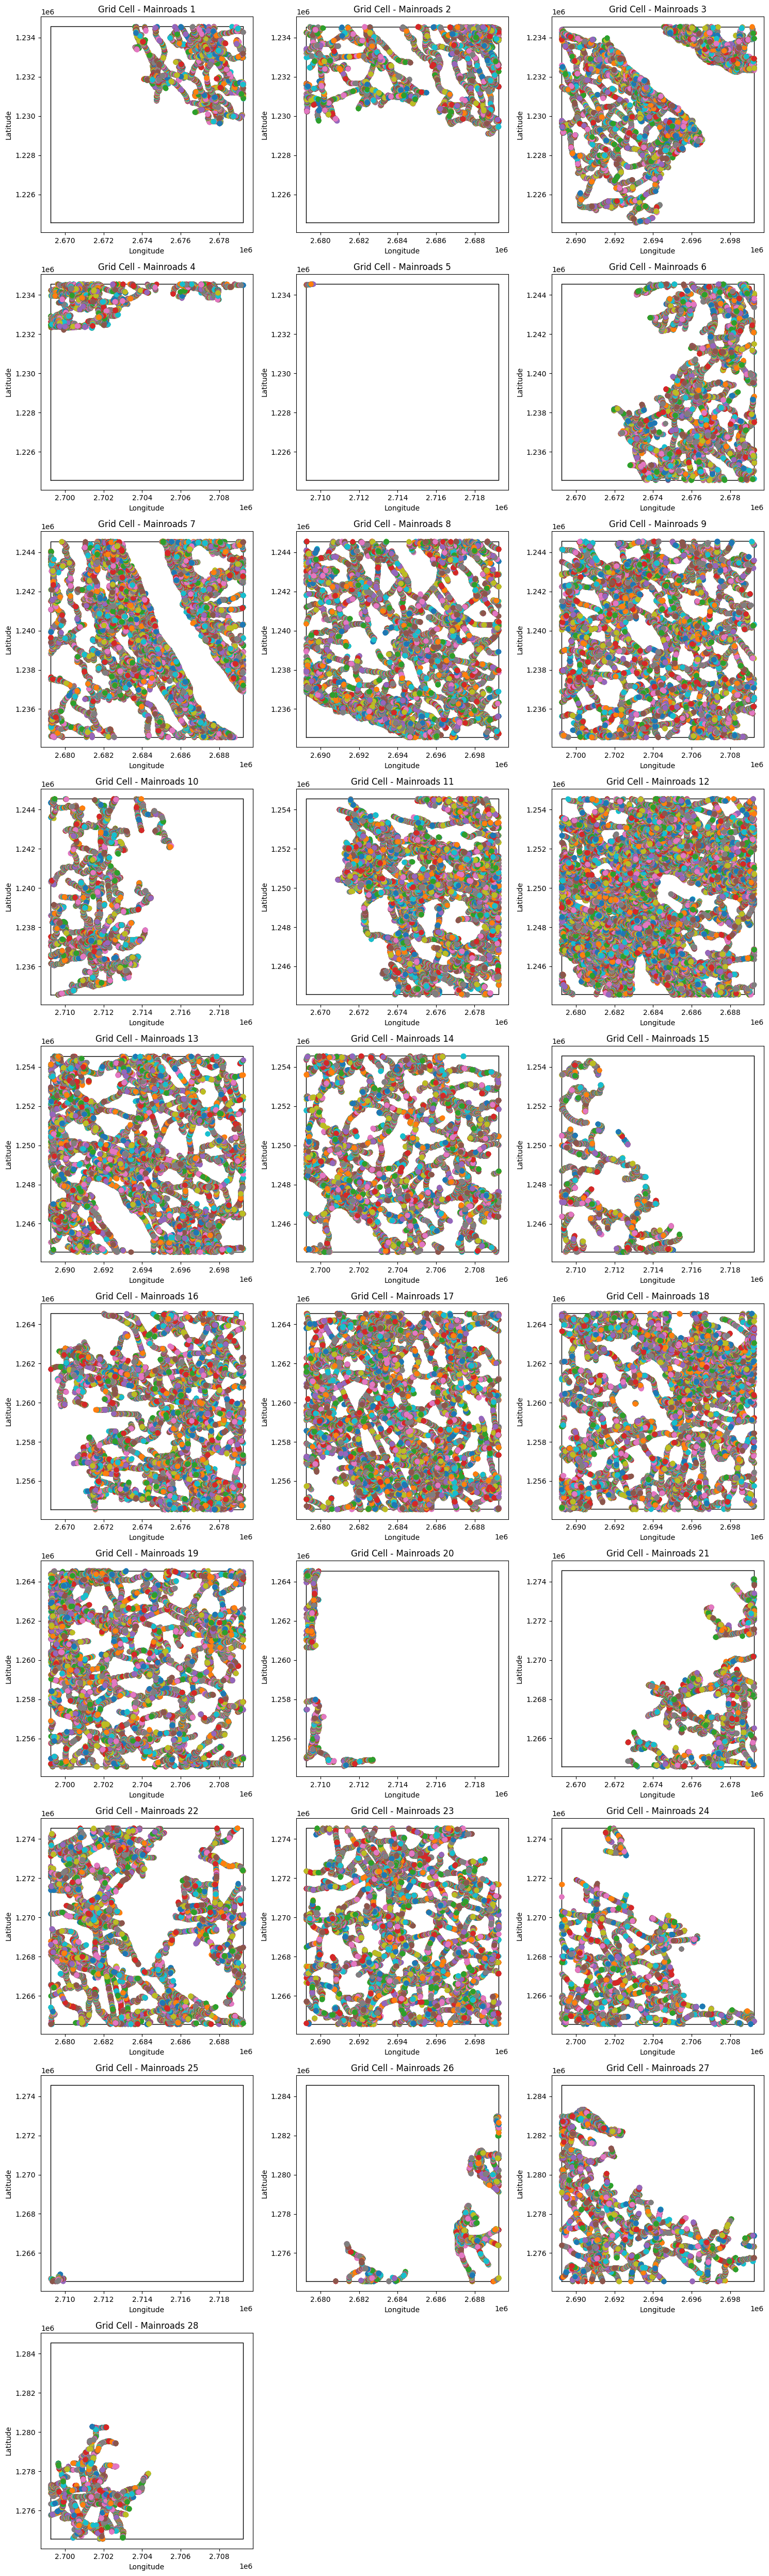

In [25]:

def plot_gridded_buffers(gridded_buffers, grid_polygons, title_prefix='Grid Cell'):
    cells_with_buffers = [(grid, buffers) for grid, buffers in zip(grid_polygons, gridded_buffers) if buffers]
    
    num_cells = len(cells_with_buffers)
    if num_cells == 0:
        print("No grid cells contain buffered segments.")
        return

    cols = 3
    rows = (num_cells // cols) + (num_cells % cols > 0)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axs = axs.flatten()

    for i, (grid, buffers) in enumerate(cells_with_buffers):
        x_grid = [point.x for point in grid.get_points()]
        y_grid = [point.y for point in grid.get_points()]
        axs[i].plot(x_grid, y_grid, 'k-', linewidth=1)

        for buffer in buffers:
            x_buffer = [point.x for point in buffer.get_points()]
            y_buffer = [point.y for point in buffer.get_points()]
            axs[i].plot(x_buffer, y_buffer, marker='o')
        
        axs[i].set_title(f'{title_prefix} {i+1}')
        axs[i].set_xlabel('Longitude')
        axs[i].set_ylabel('Latitude')

    for j in range(len(cells_with_buffers), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

# Plotting the gridded buffers for Zurich Swiss Topo motorways
#plot_gridded_buffers(buffered_motorway_zh_swisstopo, grid_polygons_motorway_zh_swisstopo, title_prefix='Grid Cell - Motorway')
plot_gridded_buffers(buffered_mainroads_zh_swisstopo, grid_polygons_mainroads_zh_swisstopo, title_prefix='Grid Cell - Mainroads')


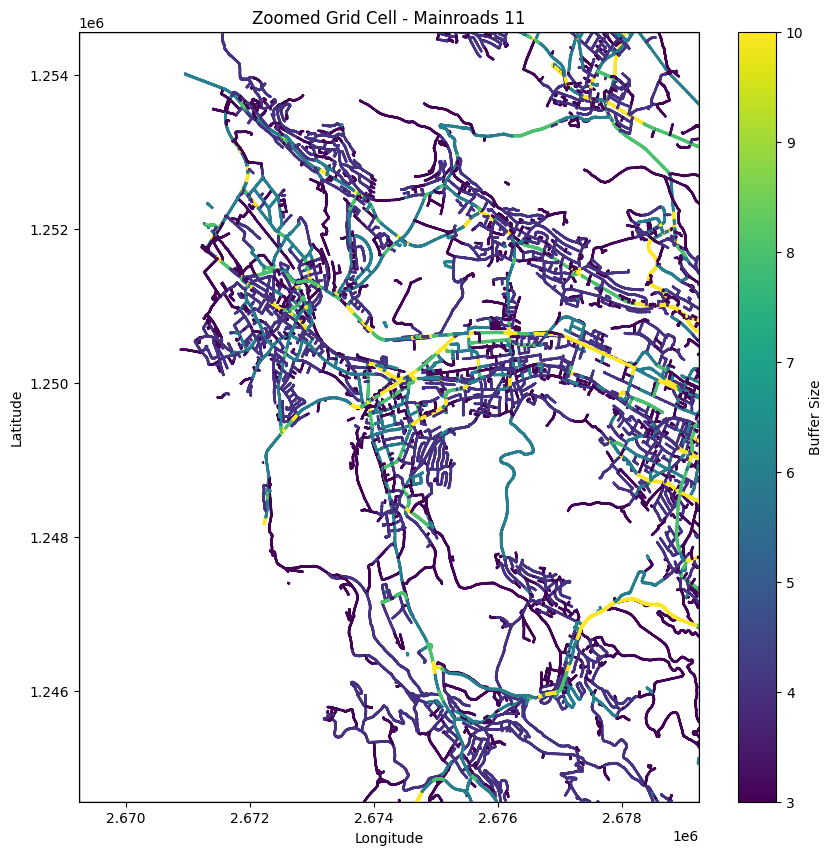

In [26]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_zoomed_grid_cell_with_colored_buffers(grid_cell_index, gridded_buffers, gridded_segments, grid_polygons, title_prefix='Grid Cell'):
    if grid_cell_index >= len(gridded_buffers) or not gridded_buffers[grid_cell_index]:
        print(f"No buffers in the specified grid cell index {grid_cell_index}.")
        return

    grid = grid_polygons[grid_cell_index]
    buffers = gridded_buffers[grid_cell_index]
    segments = gridded_segments[grid_cell_index]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the grid cell
    x_grid = [point.x for point in grid.get_points()]
    y_grid = [point.y for point in grid.get_points()]
    ax.plot(x_grid, y_grid, 'k-', linewidth=1, label='Grid Cell')

    # Plot the original segments
    for segment in segments:
        x_segment = [segment.start.x, segment.end.x]
        y_segment = [segment.start.y, segment.end.y]
        ax.plot(x_segment, y_segment, 'b-')

    # Normalize buffer sizes for coloring
    buffer_sizes = [seg.buffer for seg in segments]
    norm = mcolors.Normalize(vmin=min(buffer_sizes), vmax=max(buffer_sizes))
    colormap = cm.viridis

    # Plot the buffered segments with colors based on buffer size
    for buffer, segment in zip(buffers, segments):
        x_buffer = [point.x for point in buffer.get_points()]
        y_buffer = [point.y for point in buffer.get_points()]
        color = colormap(norm(segment.buffer))
        ax.plot(x_buffer, y_buffer, color=color, label=f'Buffered Segment (Buffer={segment.buffer})')

    ax.set_title(f'{title_prefix} {grid_cell_index + 1}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Set limits to zoom into the grid cell
    ax.set_xlim(min(x_grid), max(x_grid))
    ax.set_ylim(min(y_grid), max(y_grid))

    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax, label='Buffer Size')
    plt.show()

# Select a specific grid cell to zoom into
zoom_grid_cell_index = 10  # Change this to the index of the grid cell you want to zoom into

# Plotting the zoomed grid cell for Zurich Swiss Topo motorways
plot_zoomed_grid_cell_with_colored_buffers(zoom_grid_cell_index, buffered_mainroads_zh_swisstopo, gridded_mainroads_zh_swisstopo, grid_polygons_mainroads_zh_swisstopo, title_prefix='Zoomed Grid Cell - Mainroads')

### Calling the Merge function

As we had troubles with getting the merge function to run (see documentation) we decided to implement a merge function from the packages shapely and geopandas.

In [41]:
import shapely as shp
import geopandas as gpd

def into_geopandas(buffered_gridded_polygons):
    shapely = []
    for gridcell in buffered_gridded_polygons:
        if len(gridcell) != 0:
            cell_polys = []
            for poly in gridcell:
                point_list = [(point.x,point.y) for point in poly.points]
                cell_polys.append(shp.Polygon(point_list))
            if len(cell_polys) != 0:
                shapely.append(cell_polys)
    geopandas = []
    for gridcell_polys in shapely:
        indices = range(1,len(gridcell_polys)+1)
        gdf = gpd.GeoDataFrame(dict(id=indices), geometry=gridcell_polys)
        if len(gdf) != 0:
            geopandas.append(gdf)
    return geopandas

# Put data into Geopandas dataframes
geopanda_buffered_motorway_zh_swisstopo = into_geopandas(buffered_motorway_zh_swisstopo)
geopanda_buffered_mainroads_zh_swisstopo = into_geopandas(buffered_mainroads_zh_swisstopo)
geopanda_buffered_smallpaths_zh_swisstopo = into_geopandas(buffered_smallpaths_zh_swisstopo)
print("Converted Swiss Topo buffers for Zurich")


geopanda_buffered_motorway_zh_osm = into_geopandas(buffered_motorway_zh_osm)
geopanda_buffered_mainroads_without_zh_osm = into_geopandas(buffered_mainroads_without_zh_osm)
geopanda_buffered_mainroads_with_zh_osm = into_geopandas(buffered_mainroads_with_zh_osm)
geopanda_buffered_smallpaths_without_zh_osm = into_geopandas(buffered_smallpaths_without_zh_osm)
geopanda_buffered_smallpaths_with_zh_osm = into_geopandas(buffered_smallpaths_with_zh_osm)
print("Converted OSM buffers for Zurich")


geopanda_buffered_motorway_gr_swisstopo = into_geopandas(buffered_motorway_gr_swisstopo)
geopanda_buffered_mainroads_gr_swisstopo = into_geopandas(buffered_mainroads_gr_swisstopo)
geopanda_buffered_smallpaths_gr_swisstopo = into_geopandas(buffered_smallpaths_gr_swisstopo)
print("Converted Swiss Topo buffers for Graubunden")

geopanda_buffered_motorway_gr_osm = into_geopandas(buffered_motorway_gr_osm)
geopanda_buffered_mainroads_without_gr_osm = into_geopandas(buffered_mainroads_without_gr_osm)
geopanda_buffered_mainroads_with_gr_osm = into_geopandas(buffered_mainroads_with_gr_osm)
geopanda_buffered_smallpaths_without_gr_osm = into_geopandas(buffered_smallpaths_without_gr_osm)
geopanda_buffered_smallpaths_with_gr_osm = into_geopandas(buffered_smallpaths_with_gr_osm)
print("Converted OSM buffers for Graubunden")


print("Converted all buffers")

Converted Swiss Topo buffers for Zurich
Converted OSM buffers for Zurich
Converted all buffers


Now we use the converted datasets to merge the buffers per grid cell:

In [45]:
def merge_geopandas(gdf_list):
    merged_all = []
    for gridcell_gdf in gdf_list:
        merged = gridcell_gdf.dissolve().explode(index_parts=True)
    merged_all.append(merged)
    return merged_all

merged_geopanda_buffered_motorway_zh_swisstopo = merge_geopandas(geopanda_buffered_motorway_zh_swisstopo)
merged_geopanda_buffered_mainroads_zh_swisstopo = merge_geopandas(geopanda_buffered_mainroads_zh_swisstopo)
merged_geopanda_buffered_smallpaths_zh_swisstopo = merge_geopandas(geopanda_buffered_smallpaths_zh_swisstopo)
print("Merged Swiss Topo buffers for Zurich")


merged_geopanda_buffered_motorway_zh_osm = merge_geopandas(geopanda_buffered_motorway_zh_osm)
merged_geopanda_buffered_mainroads_without_zh_osm = merge_geopandas(geopanda_buffered_mainroads_without_zh_osm)
merged_geopanda_buffered_mainroads_with_zh_osm = merge_geopandas(geopanda_buffered_mainroads_with_zh_osm)
merged_geopanda_buffered_smallpaths_without_zh_osm = merge_geopandas(geopanda_buffered_smallpaths_without_zh_osm)
merged_geopanda_buffered_smallpaths_with_zh_osm = merge_geopandas(geopanda_buffered_smallpaths_with_zh_osm)
print("Merged OSM buffers for Zurich")

merged_geopanda_buffered_motorway_gr_swisstopo = merge_geopandas(geopanda_buffered_motorway_gr_swisstopo)
merged_geopanda_buffered_mainroads_gr_swisstopo = merge_geopandas(geopanda_buffered_mainroads_gr_swisstopo)
merged_geopanda_buffered_smallpaths_gr_swisstopo = merge_geopandas(geopanda_buffered_smallpaths_gr_swisstopo)
print("Merged Swiss Topo buffers for Graubunden")

merged_geopanda_buffered_motorway_gr_osm = merge_geopandas(geopanda_buffered_motorway_gr_osm)
merged_geopanda_buffered_mainroads_without_gr_osm = merge_geopandas(geopanda_buffered_mainroads_without_gr_osm)
merged_geopanda_buffered_mainroads_with_gr_osm = merge_geopandas(geopanda_buffered_mainroads_with_gr_osm)
merged_geopanda_buffered_smallpaths_without_gr_osm = merge_geopandas(geopanda_buffered_smallpaths_without_gr_osm)
merged_geopanda_buffered_smallpaths_with_gr_osm = merge_geopandas(geopanda_buffered_smallpaths_with_gr_osm)
print("Merged OSM buffers for Graubunden")


print("Merged all buffers")


Merged Swiss Topo buffers for Zurich
Merged OSM buffers for Zurich
Merged Swiss Topo buffers for Graubunden
Merged OSM buffers for Graubunden
Merged all buffers


Now we can calculate the pairwise swisstopo-osm intersections and corresponding areas for the final analysis.

In [46]:
def geopandas_intersection(swisstopo, osm):
    intersections = []
    intersections_area = []
    for i in range(len(swisstopo)):
        intersection = swisstopo[i].intersection(osm[i])
        intersections.append(intersection)
        intersections_area.append(intersection.area)

    return intersections, intersections_area

intersections_motorway_zh, intersections_motorway_zh_area = geopandas_intersection(merged_geopanda_buffered_motorway_zh_swisstopo, merged_geopanda_buffered_motorway_zh_osm)
intersections_mainroads_with_zh, intersections_mainroads_with_zh_area = geopandas_intersection(merged_geopanda_buffered_mainroads_zh_swisstopo, merged_geopanda_buffered_mainroads_with_zh_osm)
intersections_mainroads_without_zh, intersections_mainroads_without_zh_area = geopandas_intersection(merged_geopanda_buffered_mainroads_zh_swisstopo, merged_geopanda_buffered_mainroads_without_zh_osm)
intersections_smallpaths_with_zh, intersections_smallpaths_with_zh_area = geopandas_intersection(merged_geopanda_buffered_smallpaths_zh_swisstopo, merged_geopanda_buffered_smallpaths_with_zh_osm)
intersections_smallpaths_without_zh, intersections_smallpaths_without_zh_area = geopandas_intersection(merged_geopanda_buffered_smallpaths_zh_swisstopo, merged_geopanda_buffered_smallpaths_without_zh_osm)
print("Calculated intersections for Zurich")

intersections_motorway_gr, intersections_motorway_gr_area = geopandas_intersection(merged_geopanda_buffered_motorway_gr_swisstopo, merged_geopanda_buffered_motorway_gr_osm)
intersections_mainroads_with_gr, intersections_mainroads_with_gr_area = geopandas_intersection(merged_geopanda_buffered_mainroads_gr_swisstopo, merged_geopanda_buffered_mainroads_with_gr_osm)
intersections_mainroads_without_gr, intersections_mainroads_without_gr_area = geopandas_intersection(merged_geopanda_buffered_mainroads_gr_swisstopo, merged_geopanda_buffered_mainroads_without_gr_osm)
intersections_smallpaths_with_gr, intersections_smallpaths_with_gr_area = geopandas_intersection(merged_geopanda_buffered_smallpaths_gr_swisstopo, merged_geopanda_buffered_smallpaths_with_gr_osm)
intersections_smallpaths_without_gr, intersections_smallpaths_without_gr_area = geopandas_intersection(merged_geopanda_buffered_smallpaths_gr_swisstopo, merged_geopanda_buffered_smallpaths_without_gr_osm)
print("Calculated intersections for Graubunden")


print("Calculated all intersections")

C:\Users\ahvidt\AppData\Local\Temp\323\ipykernel_55948\3758727985.py:5: UserWarning: The indices of the two GeoSeries are different.
  intersection = swisstopo[i].intersection(osm[i])


Calculated intersections for Zurich
Calculated intersections for Graubunden
Calculated all intersections



Finally, we need to calculate all areas of the merged osm buffers to get our accuracy values.

In [47]:
def buffer_area(gdf_list):
    areas = []
    for gdf in gdf_list:
        areas.append(gdf.area)
    return areas

motorway_zh_osm_area = buffer_area(merged_geopanda_buffered_motorway_zh_osm)
mainroads_with_zh_osm_area = buffer_area(merged_geopanda_buffered_mainroads_with_zh_osm)
mainroads_without_zh_osm_area = buffer_area(merged_geopanda_buffered_mainroads_without_zh_osm)
smallpaths_with_zh_osm_area = buffer_area(merged_geopanda_buffered_smallpaths_with_zh_osm)
smallpaths_without_zh_osm_area = buffer_area(merged_geopanda_buffered_smallpaths_without_zh_osm)
print("Calculated osm areas for Zurich")


motorway_gr_osm_area = buffer_area(merged_geopanda_buffered_motorway_gr_osm)
mainroads_with_gr_osm_area = buffer_area(merged_geopanda_buffered_mainroads_with_gr_osm)
mainroads_without_gr_osm_area = buffer_area(merged_geopanda_buffered_mainroads_without_gr_osm)
smallpaths_with_gr_osm_area = buffer_area(merged_geopanda_buffered_smallpaths_with_gr_osm)
smallpaths_without_gr_osm_area = buffer_area(merged_geopanda_buffered_smallpaths_without_gr_osm)
print("Calculated osm areas for Graubunden")

print("Calculated all osm areas")

Calculated osm areas for Zurich
Calculated osm areas for Graubunden
Calculated all osm areas


Now we can total accuracy per category in %.

In [51]:
def category_accuracy(intersection_area_list,osm_area_list):
    intersection_area = 0
    osm_area = 0
    for i in range(len(intersection_area_list)):
        intersection_area += np.nansum(intersection_area_list[i])
        osm_area += np.nansum(osm_area_list[i])
    return (intersection_area/osm_area)*100

print(f"Motorway ZH accuracy: {category_accuracy(intersections_motorway_zh_area, motorway_zh_osm_area)}")
print(f"Mainroads('with') ZH accuracy: {category_accuracy(intersections_mainroads_with_zh_area, mainroads_with_zh_osm_area)}")
print(f"Mainroads('without') ZH accuracy: {category_accuracy(intersections_mainroads_without_zh_area, mainroads_without_zh_osm_area)}")
print(f"Smallpaths('with') ZH accuracy: {category_accuracy(intersections_smallpaths_with_zh_area, smallpaths_with_zh_osm_area)}")
print(f"Smallpaths('without') ZH accuracy: {category_accuracy(intersections_smallpaths_without_zh_area, smallpaths_without_zh_osm_area)}")
print(f"Motorway GR accuracy: {category_accuracy(intersections_motorway_gr_area, motorway_gr_osm_area)}")
print(f"Mainroads('with') GR accuracy: {category_accuracy(intersections_mainroads_with_gr_area, mainroads_with_gr_osm_area)}")
print(f"Mainroads('without') GR accuracy: {category_accuracy(intersections_mainroads_without_gr_area, mainroads_without_gr_osm_area)}")
print(f"Smallpaths('with') GR accuracy: {category_accuracy(intersections_smallpaths_with_gr_area, smallpaths_with_gr_osm_area)}")
print(f"Smallpaths('without') GR accuracy: {category_accuracy(intersections_smallpaths_without_gr_area, smallpaths_without_gr_osm_area)}")

Motorway ZH accuracy: 95.36248952268099
Mainroads('with') ZH accuracy: 74.06764742785073
Mainroads('without') ZH accuracy: 77.70091117013575
Smallpaths('with') ZH accuracy: 3.039668261366339
Smallpaths('without') ZH accuracy: 3.127637767446803
Motorway GR accuracy: 96.79365493367317
Mainroads('with') GR accuracy: 0.0
Mainroads('without') GR accuracy: 0.0
Smallpaths('with') GR accuracy: 7.098053462294807
Smallpaths('without') GR accuracy: 7.098053462294807
